In [596]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np

LOG.propagate = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [597]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-04-14 18:33:59,512 | INFO     |: Already connected to a BLE device


In [610]:
ble.send_command(CMD.MAP, "")
tof = []
yaw = []
times = []

In [612]:
#Prompt recording data from loop
tof = []
yaw = []
times = []
def map_handler(uuid, bytearr):
    try:
        piddata = ble.bytearray_to_string(bytearr)
        arr = piddata.split("tof:")[1] #Split messages
        tof1, arr = arr.split("yaw:")
        yaw1, time1 = arr.split("time:")
        tof.append(int(float(tof1)))
        yaw.append(int(float(yaw1)))
        times.append(int(float(time1)))
        
    except Exception as e:
        print(e)


ble.start_notify(ble.uuid['RX_STRING'], map_handler)


In [613]:
ble.send_command(CMD.SEND_MAP, "")

12 MS for pid loop
30-40 MS for TOF reading


In [617]:
ble.stop_notify(ble.uuid['RX_STRING'],)

In [618]:
#Prompt recording data from loop
prop = []
time = []
motor1 = []
motor2 = []
dist_targ = []
orient_targ = []
def pid_data_handler(uuid, bytearr):
    try:
        piddata = ble.bytearray_to_string(bytearr)
        arr = piddata.split("Prop:")[1] #Split messages
        prop1, arr = arr.split("Motor1:")
        motor1a, arr = arr.split("Motor2:")
        motor2a, arr = arr.split("Time:")
        time1, arr = arr.split("dist:")
        dist, ang = arr.split("ang:")
        prop.append(int(prop1))
        motor1.append(int(motor1a))
        motor2.append(int(motor2a))
        time.append(int(time1))
        dist_targ.append(int(dist))
        orient_targ.append(int(ang))
        
    except Exception as e:
        print(e)


ble.start_notify(ble.uuid['RX_STRING'], pid_data_handler)


In [619]:
ble.send_command(CMD.GET_PID, "")

In [605]:
ble.stop_notify(ble.uuid['RX_STRING'],)

73


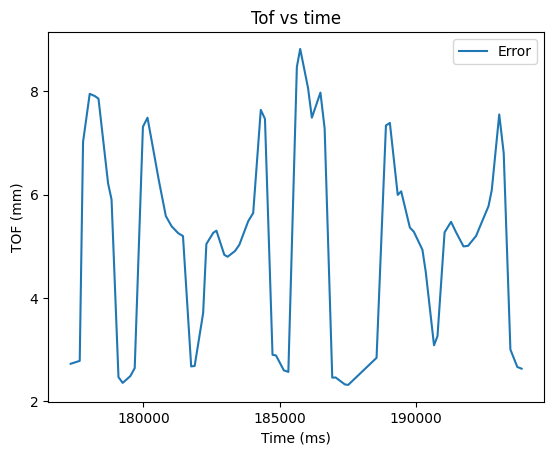

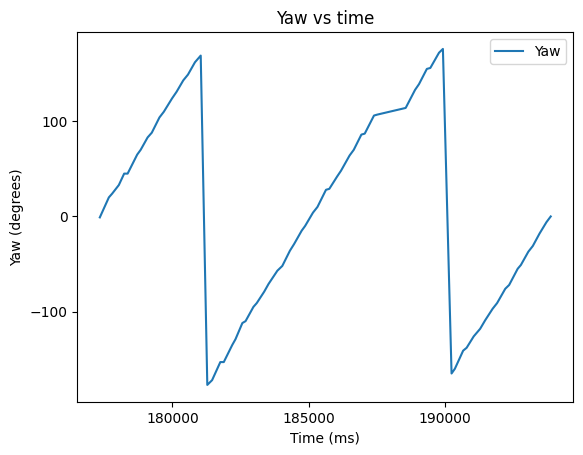

In [654]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import locator_params
import numpy as np

print(len(tof))

plt.plot(data_00["times"], data_00["tof"])


plt.locator_params(axis='x', nbins=5) 
plt.locator_params(axis='y', nbins=5) 
plt.legend(["Error"], loc="upper right")
plt.title('Tof vs time')
plt.ylabel('TOF (mm)')
plt.xlabel('Time (ms)')
plt.show()


plt.plot(data_00["times"], data_00["yaw"])

plt.locator_params(axis='x', nbins=5) 
plt.locator_params(axis='y', nbins=5) 
plt.legend(["Yaw"], loc="upper right")
plt.title('Yaw vs time')
plt.ylabel('Yaw (degrees)')
plt.xlabel('Time (ms)')
plt.show()

In [649]:
import csv
from collections import defaultdict

# Function to average every n data points
def average_every_n(data, n=5):
    return [sum(data[i:i+n]) / n for i in range(0, len(data) - n + 1, n)]

def load_and_average(filename):
    data = defaultdict(list)
    with open(filename, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            for key, value in row.items():
                data[key].append(float(value))

    # Convert TOF from mm to feet
    if 'tof' in data:
        data['tof'] = [val * 0.00328084 for val in data['tof']]
        #data['tof'] = average_every_n(data['tof'], n=5)

    return data


# Load and process all datasets
data_00 = load_and_average("00.csv")
data_53 = load_and_average("53.csv")
data_03 = load_and_average("03.csv")
data_n3n2 = load_and_average("-3-2.csv")
data_5n3 = load_and_average("5-3.csv")


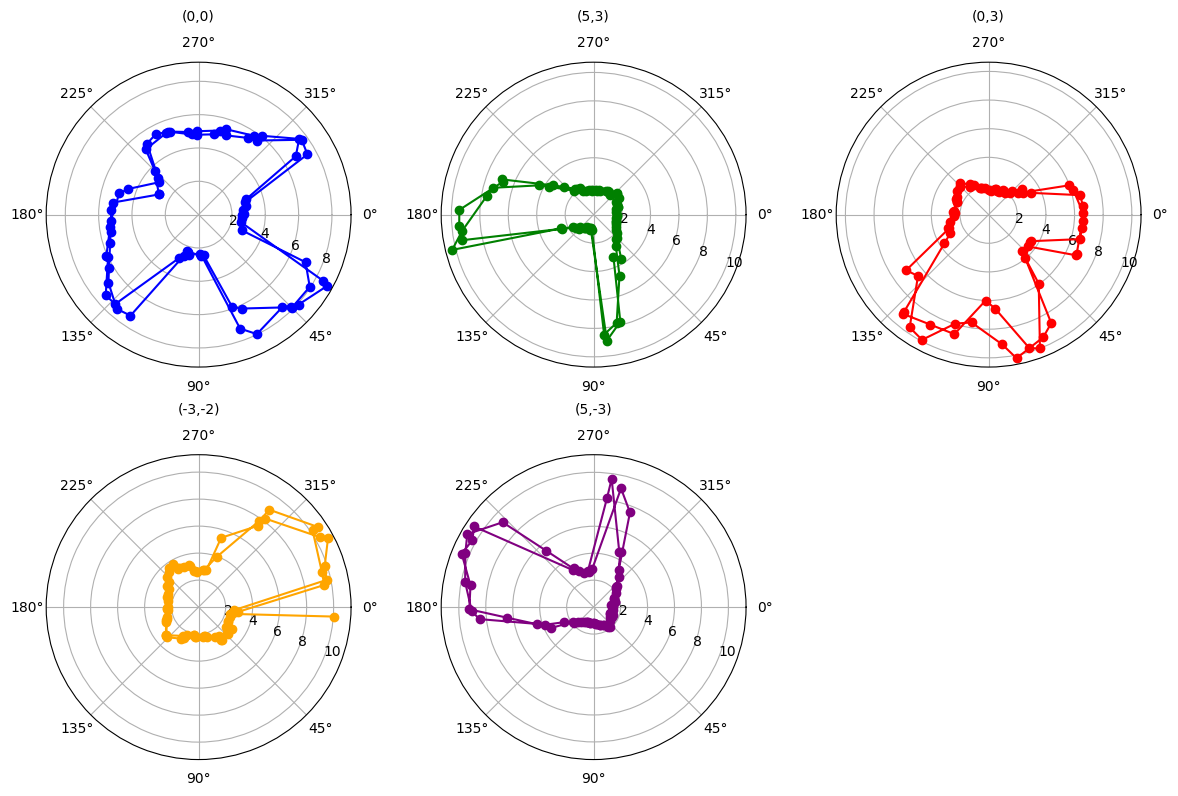

In [656]:
import matplotlib.pyplot as plt
import numpy as np

# List of your datasets and labels
datasets = [
    ("data_00", data_00),
    ("data_53", data_53),
    ("data_03", data_03),
    ("data_n3n2", data_n3n2),
    ("data_5n3", data_5n3)
]
plotnames = ["(0,0)","(5,3)","(0,3)","(-3,-2)","(5,-3)"]
colors = ['blue', 'green', 'red', 'orange', 'purple']
angles = [0, -45, -45, 0, 0]

# Set up subplots: 5 plots → 2 rows x 3 columns (leave one empty)
fig, axs = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(12, 8))

# Flatten axes for easy indexing
axs = axs.flatten()

# Loop through datasets and plot
for i, (name, dataset) in enumerate(datasets):
    ax = axs[i]
    angles_rad = np.radians([angle + angles[i] for angle in dataset["yaw"]])
    distances = dataset["tof"]

    ax.plot(angles_rad, distances, marker='o', linestyle='-', color=colors[i], label=plotnames[i])
    ax.set_title(plotnames[i], fontsize=10, pad=30) 
    ax.set_theta_zero_location("E")  # 0° on the right
    ax.set_theta_direction(-1)        # counterclockwise

# Hide any unused subplot (e.g. the 6th one)
if len(datasets) < len(axs):
    for i in range(len(datasets), len(axs)):
        fig.delaxes(axs[i])

# Adjust layout
plt.tight_layout()
plt.show()


[399, 394, 390, 429, 488, 537, 446, 421, 375, 370, 366, 364, 413, 437, 563, 1081, 1329, 1968, 2812, 2827, 3217, 3133, 3261, 953, 985, 801, 827, 2486, 2928, 1374, 1389, 711, 695, 500, 482, 436]
[434, 469, 464, 584, 548, 474, 431, 381, 369, 360, 372, 379, 489, 560, 751, 1159, 2594, 2756, 2960, 3150, 3300, 2814, 1662, 964, 887, 807, 868, 2755, 2294, 1015, 884, 658, 606, 492, 496, 451]


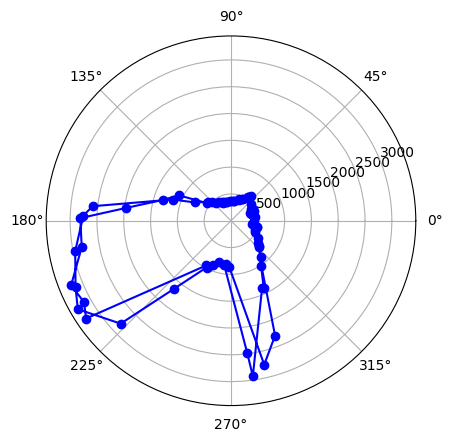

In [680]:
import matplotlib.pyplot as plt
import numpy as np



# Convert angles to radians for polar plot
angles_rad = np.radians(yaw)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles_rad, tof, marker='o', linestyle='-', color='blue')

print(tof[0:36])
print(tof[37:])


/var/folders/4x/3bgsy7kx5zj37y8f_5n26fs00000gp/T/ipykernel_62786/536079878.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_robot, y_robot, 'ro', color='black')


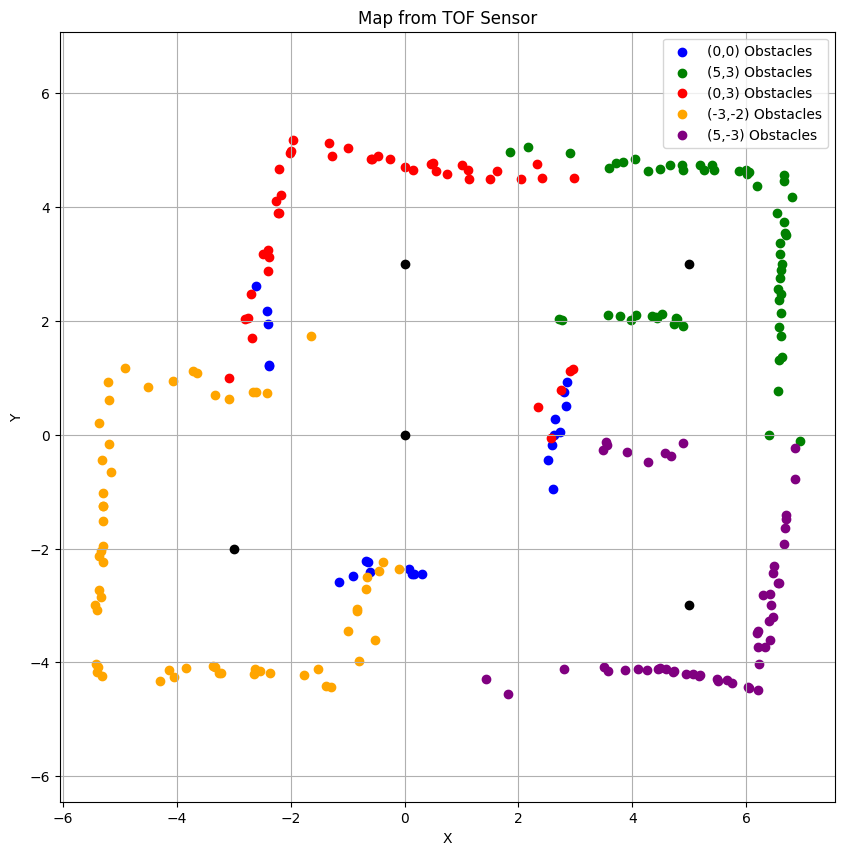

In [644]:
import numpy as np
import matplotlib.pyplot as plt

# Plot robot and obstacles
plt.figure(figsize=(10,10))

locs = [[0,0],[5,3],[0,3],[-3,-2],[5,-3]]
angles = [0, -45, -45, 0, 0]

for i, (name, dataset) in enumerate(datasets):
    ax = axs[i]
    angles_rad = np.radians([angle + angles[i] for angle in dataset["yaw"]])
    distances = dataset["tof"]

    # Robot's known position in global coordinates
    x_robot = locs[i][0]
    y_robot = locs[i][1]
    
    
    # Convert polar to cartesian
    #x_obstacles = x_robot + np.cos(angles_rad) * distances
    #y_obstacles = y_robot + -(np.sin(angles_rad) * distances)

    x_obstacles = []
    y_obstacles = []

    for j in range(len(angles_rad)):
        T = np.array([
            [np.cos(-angles_rad[j]), -np.sin(-angles_rad[j]), x_robot],
            [np.sin(-angles_rad[j]),  np.cos(-angles_rad[j]), y_robot],
            [0,                0,               1]
        ])
        # Polar point in homogeneous coordinates (r, 0, 1)^T
        if (distances[j] < 4):
            local_point = np.array([[distances[j]], [0], [1]])
        
            # Transform into global coordinates
            global_point = T @ local_point
            
            x_obstacles.append(global_point[0, 0])
            y_obstacles.append(global_point[1, 0])

    plt.plot(x_robot, y_robot, 'ro', color='black')
    plt.scatter(x_obstacles, y_obstacles, color=colors[i], label=f'{plotnames[i]} Obstacles')
    
plt.axis('equal')
plt.grid(True)
plt.title("Map from TOF Sensor")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


/var/folders/4x/3bgsy7kx5zj37y8f_5n26fs00000gp/T/ipykernel_62786/4260072580.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_robot, y_robot, 'ro', color='black')
/var/folders/4x/3bgsy7kx5zj37y8f_5n26fs00000gp/T/ipykernel_62786/4260072580.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


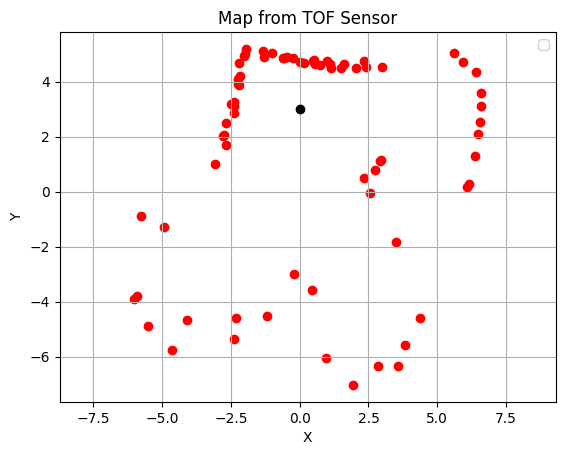

In [674]:


angles_rad = np.radians([angle + angles[2] for angle in data_03["yaw"]])
distances = (data_03["tof"])

# Robot's known position in global coordinates
x_robot = 0
y_robot = 3

x_obstacles = []
y_obstacles = []

for i in range(len(angles_rad)):
    T = np.array([
        [np.cos(-angles_rad[i]), -np.sin(-angles_rad[i]), x_robot],
        [np.sin(-angles_rad[i]),  np.cos(-angles_rad[i]), y_robot],
        [0,                0,               1]
    ])
    # Polar point in homogeneous coordinates (r, 0, 1)^T
    local_point = np.array([[distances[i]], [0], [1]])

    # Transform into global coordinates
    global_point = T @ local_point
    
    x_obstacles.append(global_point[0, 0])
    y_obstacles.append(global_point[1, 0])

plt.plot(x_robot, y_robot, 'ro', color='black')
plt.scatter(x_obstacles, y_obstacles, color = 'red')
    
plt.axis('equal')
plt.grid(True)
plt.title("Map from TOF Sensor")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


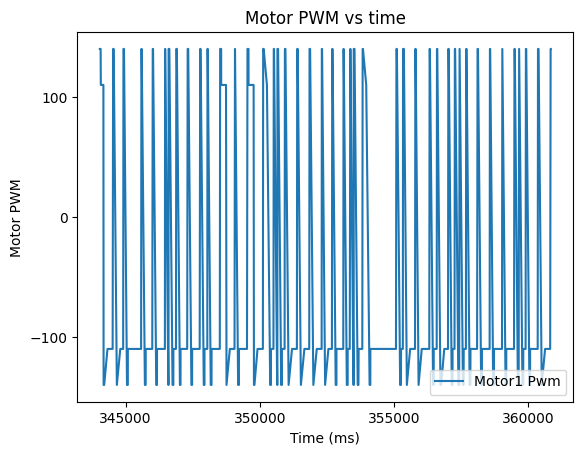

In [652]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import locator_params
import numpy as np


plt.plot(time, motor1)

plt.locator_params(axis='x', nbins=5) 
plt.locator_params(axis='y', nbins=5) 
plt.legend(["Motor1 Pwm", "Motor2 Pwm"], loc="lower right")
plt.title('Motor PWM vs time')
plt.ylabel('Motor PWM')
plt.xlabel('Time (ms)')
plt.show()

1213


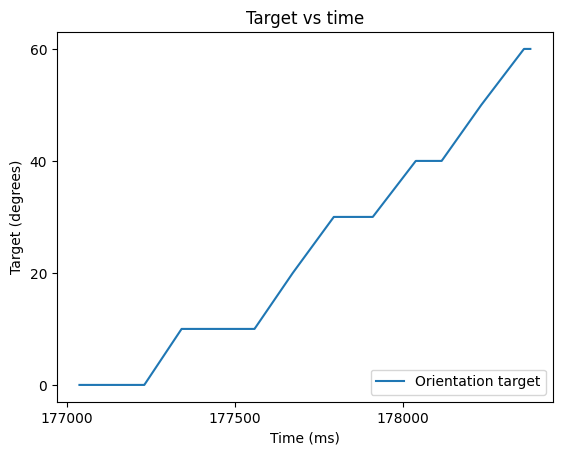

In [651]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import locator_params
import numpy as np
print(len(time))

plt.plot(data_00["time"], data_00["orient_targ"])

plt.locator_params(axis='x', nbins=5) 
plt.locator_params(axis='y', nbins=5) 
plt.legend(["Orientation target"], loc="lower right")
plt.title('Target vs time')
plt.ylabel('Target (degrees)')
plt.xlabel('Time (ms)')
plt.show()

In [628]:
import csv


# Zip all lists together into rows
rows = zip(tof, yaw, times, motor1, orient_targ, time)

# Save to CSV
with open("5-3.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["tof", "yaw", "times", "motor", "orient_targ", "times"])  # Header
    writer.writerows(rows)

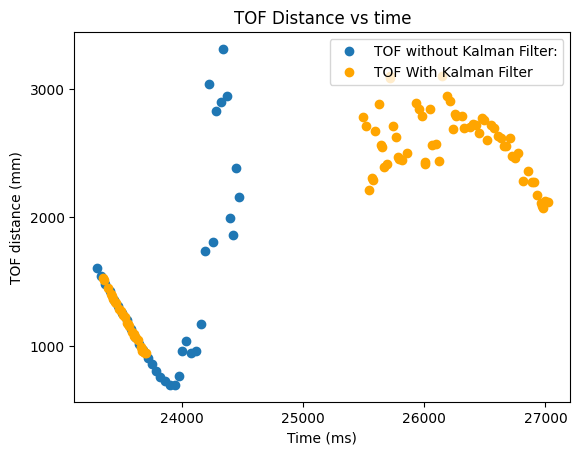

In [439]:
tof_orig = []
tof_origt = []
tof_kal = []
tof_kalt = []
for i in range(len(tof_arr1)):
    if (int(tof_arr1[i]) == tof_arr1[i]):
        tof_orig.append(tof_arr1[i])
        tof_origt.append(tofstamps[i])
    else:
        tof_kal.append(tof_arr1[i])
        tof_kalt.append(tofstamps[i])

plt.plot(tof_origt[40:76], tof_orig[40:76], 'o')
plt.plot(tof_kalt[85:175], tof_kal[85:175], 'o', color='orange')
plt.locator_params(axis='x', nbins=5) 
plt.locator_params(axis='y', nbins=5) 
plt.legend(["TOF without Kalman Filter:", "TOF With Kalman Filter"], loc="upper right")
plt.title('TOF Distance vs time')
plt.ylabel('TOF distance (mm)')
plt.xlabel('Time (ms)')
plt.show()

In [742]:
motor = [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 69, 69, 69, 68, 68, 68, 68, 68, 68, 67, 67, 67, 67, 66, 66, 66, 66, 66, 65, 65, 65, 65, 65, 65, 64, 64, 63, 63, 63, 62, 62, 62, 61, 61, 60, 60, 60, 59, 59, 58, 58, 57, 57, 57, 56, 56, 55, 54, 54, 53, 53, 53, 52, 52, 51, 51, 51, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, -70, -70, -70, -70, -70, -70, -70, -70, -70, -70, -70, -70, -70, -70, -70, -70, -70, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -70, -70, -70, -70, -70, -70, -70, -70, -70, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 70, 70, 70, 70, 70, 70, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, -70, -70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 50, -70, -70, -70, -70, -70, -70, -70, -70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 50, -70, -70, -70, -70, -70, -70, -70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 70, 70, 70, 70, -70, -70, -70, -70, -70, -70, -70, -70, -70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 70, 70, -70, -70, -70, -70, -70, 70, 70, 70, 70, 70, 70, 70, 70, 50, 50, -70, -70, -70, -70, -70, -70, -70, -70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 70, 70, 70, 70, 70, 70, 70, 50, 50, -70, 70, 70, 70, 70, 70, 70, 70, -70, -70, -70, -70, -70, -70, -70, -70, -70, -70, 0]
tof_arr1 = [1480.256, 1480.538, 1475.0, 1473.472, 1471.25, 1473.0, 1472.421, 1467.0, 1463.363, 1461.545, 1464.0, 1463.153, 1462.0, 1454.0, 1448.054, 1441.0, 1435.184, 1432.105, 1436.0, 1434.108, 1432.351, 1422.0, 1417.947, 1414.631, 1411.315, 1406.0, 1400.322, 1394.645, 1397.0, 1394.0, 1391.0, 1382.0, 1376.545, 1371.545, 1378.0, 1376.705, 1374.941, 1358.0, 1351.714, 1345.428, 1341.428, 1338.0, 1327.0, 1320.0, 1311.947, 1309.105, 1300.0, 1291.875, 1285.0, 1279.0, 1273.224, 1266.4, 1253.0, 1244.828, 1241.114, 1232.942, 1229.0, 1220.789, 1213.842, 1202.0, 1184.0, 1184.0, 1174.129, 1171.225, 1159.0, 1147.97, 1146.0, 1139.5, 1137.062, 1133.406, 1117.0, 1109.75, 1099.204, 1088.0, 1079.138, 1070.277, 1072.0, 1067.809, 1063.619, 1039.0, 1019.0, 1011.0, 995.645, 986.612, 993.0, 988.909, 984.409, 964.0, 945.875, 935.906, 939.0, 936.023, 931.261, 924.714, 911.0, 902.2, 889.4, 887.0, 873.105, 862.0, 853.666, 845.333, 837.0, 824.878, 820.0, 806.606, 797.0, 787.315, 780.657, 767.0, 753.578, 746.473, 741.0, 725.54, 712.0, 696.181, 686.515, 689.0, 682.674, 679.799, 675.2, 660.0, 650.885, 641.771, 634.0, 618.242, 609.575, 613.0, 605.404, 600.489, 576.0, 566.309, 556.619, 547.0, 537.885, 528.771, 520.0, 512.184, 504.368, 485.0, 471.212, 459.545, 465.0, 458.125, 451.25, 439.0, 434.21, 431.473, 427.368, 419.842, 420.0, 415.25, 409.636, 388.0, 377.942, 373.371, 363.314, 358.0, 349.315, 340.631, 323.0, 308.151, 294.363, 298.0, 293.714, 290.857, 290.142, 288.714, 287.285, 285.857, 279.428, 277.285, 275.857, 277.0, 271.909, 270.636, 266.818, 265.545, 264.272, 256.0, 244.187, 236.968, 241.0, 236.285, 231.571, 220.0, 211.09, 202.818, 214.0, 211.315, 210.052, 208.315, 207.0, 204.711, 203.769, 202.961, 202.0, 200.039, 205.0, 206.064, 206.548, 207.322, 210.0, 211.142, 212.714, 213.857, 219.0, 221.918, 225.81, 216.0, 214.058, 224.0, 226.666, 230.545, 228.0, 229.473, 230.631, 234.0, 236.0, 237.09, 239.09, 244.0, 246.972, 251.027, 253.0, 257.135, 258.594, 259.567, 257.0, 258.333, 259.181, 260.515, 261.0, 262.6, 263.7, 275.0, 281.263, 284.947, 286.0, 289.184, 290.921, 291.5, 292.078, 294.394, 294.973, 298.0, 299.0, 301.333, 304.333, 305.0, 307.666, 309.0, 311.062, 311.75, 312.437, 315.187, 315.875, 317.937, 318.625, 319.0, 319.571, 320.142, 321.571, 322.142, 327.285, 319.0, 319.0, 319.0, 319.0, 319.0, 328.0, 329.636, 332.363, 335.363, 324.0, 322.21, 321.157, 329.0, 331.051, 332.461, 324.0, 321.105, 321.0, 319.909, 318.909, 312.0, 308.558, 305.647, 312.0, 312.0, 312.0, 312.0, 312.0, 312.0, 312.0, 312.0, 312.0, 312.0, 305.0, 303.288, 302.822, 301.733, 301.422, 300.644, 300.177, 302.0, 301.363, 300.636, 300.363, 299.727, 299.545, 299.363, 299.0, 298.333, 298.166, 297.666, 297.5, 297.25, 296.75, 296.5, 294.0, 293.558, 293.264, 292.823, 292.529, 292.235, 290.911, 290.323, 290.029, 289.735, 301.0, 301.875, 303.187, 303.625, 304.062, 306.031, 307.562, 307.781, 307.0, 307.333, 307.666, 308.5, 308.833, 309.166, 310.5, 311.0, 302.0, 301.189, 300.918, 300.783, 300.513, 299.297, 298.351, 298.081, 300.0, 299.837, 299.459, 299.297, 298.864, 298.756, 298.324, 295.0, 294.393, 294.09, 293.787, 292.575, 292.272, 291.212, 290.909, 290.454, 302.0, 303.272, 303.696, 304.121, 305.606, 306.242, 307.515, 307.939, 308.363, 300.0, 299.631, 299.578, 299.473, 299.052, 298.947, 298.684, 298.578, 298.473, 301.0, 301.305, 301.527, 301.611, 301.75, 301.805, 300.0, 299.75, 299.687, 299.531, 299.437, 299.187, 299.125, 298.968, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 296.0, 295.096, 294.838, 294.58, 293.806, 293.419, 292.774, 292.516, 292.387, 300.0, 301.028, 301.257, 301.485, 301.828, 302.057, 302.857, 303.085, 303.314, 301.0, 301.399, 301.657, 301.685, 301.828, 302.0, 302.354, 302.483, 302.548, 302.612, 302.903, 307.0, 307.441, 307.735, 310.235, 299.0, 295.848, 295.121, 294.636, 292.696, 300.0, 300.088, 300.205, 300.264, 300.411, 300.47, 300.529, 300.764, 296.0, 295.647, 295.176, 294.941, 294.705, 294.352, 294.117, 293.882, 293.058, 292.941, 292.705, 305.0, 306.125, 306.687, 306.968, 307.812, 308.375, 308.937, 311.187, 312.031, 302.0, 300.935, 299.677, 303.0, 303.285, 303.428, 303.457, 303.514, 303.742, 303.799, 299.0, 297.451, 296.419, 296.29, 295.774, 295.516, 295.129, 295.0, 294.5, 294.25, 293.375, 291.75, 291.25, 297.0, 297.363, 297.484, 297.606, 298.03]
tofstamps = [28384, 28395, 28411, 28421, 28437, 28449, 28459, 28484, 28501, 28511, 28521, 28531, 28546, 28558, 28579, 28597, 28612, 28621, 28633, 28646, 28659, 28673, 28681, 28690, 28699, 28702, 28712, 28723, 28735, 28745, 28756, 28768, 28779, 28790, 28802, 28812, 28827, 28837, 28847, 28858, 28865, 28877, 28898, 28920, 28931, 28937, 28947, 28959, 28970, 28987, 28997, 29010, 29022, 29032, 29037, 29048, 29060, 29072, 29083, 29090, 29109, 29121, 29137, 29142, 29155, 29169, 29192, 29202, 29208, 29217, 29231, 29241, 29257, 29267, 29277, 29288, 29309, 29319, 29330, 29342, 29361, 29373, 29389, 29399, 29417, 29426, 29437, 29451, 29468, 29479, 29491, 29495, 29503, 29514, 29526, 29536, 29552, 29564, 29585, 29597, 29607, 29618, 29631, 29645, 29663, 29688, 29701, 29716, 29727, 29739, 29755, 29764, 29776, 29797, 29809, 29826, 29837, 29849, 29859, 29864, 29872, 29884, 29894, 29905, 29917, 29936, 29947, 29964, 29980, 29991, 30006, 30016, 30027, 30041, 30051, 30062, 30080, 30089, 30100, 30112, 30124, 30135, 30144, 30154, 30165, 30183, 30188, 30192, 30198, 30209, 30226, 30236, 30249, 30261, 30271, 30276, 30287, 30299, 30309, 30320, 30332, 30345, 30358, 30367, 30373, 30376, 30377, 30379, 30381, 30383, 30392, 30395, 30397, 30400, 30407, 30409, 30415, 30417, 30419, 30432, 30449, 30460, 30467, 30477, 30488, 30500, 30513, 30526, 30543, 30554, 30562, 30573, 30590, 30606, 30613, 30619, 30641, 30660, 30672, 30682, 30687, 30695, 30707, 30714, 30725, 30733, 30744, 30755, 30771, 30778, 30799, 30811, 30821, 30837, 30850, 30862, 30873, 30882, 30892, 30898, 30909, 30919, 30929, 30944, 30956, 30972, 30978, 30982, 30989, 30999, 31006, 31017, 31029, 31044, 31055, 31067, 31083, 31093, 31105, 31115, 31121, 31123, 31125, 31133, 31135, 31141, 31143, 31150, 31159, 31161, 31169, 31173, 31178, 31180, 31182, 31190, 31192, 31198, 31200, 31208, 31209, 31211, 31216, 31218, 31236, 31253, 31259, 31263, 31269, 31280, 31286, 31291, 31301, 31312, 31324, 31340, 31350, 31363, 31378, 31389, 31401, 31422, 31434, 31445, 31456, 31468, 31480, 31491, 31500, 31504, 31507, 31509, 31510, 31515, 31517, 31520, 31528, 31530, 31545, 31555, 31558, 31565, 31567, 31572, 31575, 31582, 31584, 31592, 31595, 31602, 31604, 31606, 31614, 31621, 31623, 31629, 31631, 31634, 31640, 31643, 31648, 31650, 31652, 31655, 31657, 31659, 31668, 31672, 31674, 31676, 31681, 31683, 31689, 31691, 31693, 31702, 31709, 31710, 31716, 31718, 31719, 31724, 31726, 31728, 31736, 31739, 31753, 31758, 31760, 31761, 31763, 31772, 31779, 31781, 31790, 31792, 31799, 31802, 31811, 31812, 31820, 31823, 31826, 31828, 31830, 31838, 31840, 31847, 31849, 31852, 31856, 31861, 31863, 31865, 31872, 31875, 31881, 31883, 31885, 31894, 31900, 31902, 31903, 31911, 31913, 31918, 31920, 31922, 31930, 31940, 31948, 31951, 31956, 31958, 31967, 31969, 31971, 31976, 31979, 31987, 31989, 31994, 31998, 32004, 32006, 32008, 32015, 32017, 32025, 32026, 32033, 32036, 32042, 32044, 32046, 32052, 32055, 32061, 32064, 32070, 32072, 32074, 32080, 32084, 32088, 32090, 32092, 32100, 32107, 32109, 32111, 32114, 32116, 32123, 32125, 32127, 32134, 32147, 32156, 32157, 32162, 32165, 32175, 32179, 32181, 32183, 32192, 32199, 32201, 32203, 32220, 32233, 32244, 32247, 32249, 32257, 32266, 32268, 32272, 32274, 32279, 32281, 32283, 32291, 32300, 32302, 32306, 32308, 32310, 32313, 32315, 32317, 32324, 32325, 32327, 32332, 32335, 32337, 32338, 32341, 32343, 32345, 32353, 32356, 32363, 32373, 32386, 32398, 32407, 32412, 32414, 32415, 32423, 32425, 32430, 32440, 32448, 32450, 32453, 32455, 32458, 32462, 32464, 32466, 32473, 32486, 32490, 32494, 32499, 32501, 32503, 32510]

In [743]:

#d = .2386/1000
#m = .1579/1000
d = .3163/1000
m = .2093/1000

A = np.array([[0,1],[0,-d/m]])
B = np.array([[0],[1/m]])

testtof = tofstamps
testdata = tof_arr1

dt = []
summing = 0
for i in range(len(testtof)-1):
    dt =  (testtof[i+1] - testtof[i])/1000
    summing = summing+dt
Delt_T = summing/len(testtof)

Ad = np.eye(2) + 0.008*A
Bd = 0.008*B
print(Ad)
print(Bd)
C = np.array([[1,0]])


[[1.         0.008     ]
 [0.         0.98791018]]
[[ 0.        ]
 [38.22264692]]


In [757]:
sigma_3 = 2000 #plus or minus 20 mm data
sigma_1 = np.sqrt(0.005**2*1/Delt_T)
sigma_2 = np.sqrt(0.02**2*1/Delt_T)

sig_u=np.array([[sigma_1**2,0],[0,sigma_2**2]]) #We assume uncorrelated noise, and therefore a diagonal matrix works.
sig_z=np.array([[sigma_3**2]])

print(sig_u)
print(sig_z)
print(Delt_T)



[[0.00310228 0.        ]
 [0.         0.04963645]]
[[4000000]]
0.008058593749999938


In [758]:
def kf(mu,sigma,u,y,newTOF, printing): #always do both steps form moment
    
    mu_p = Ad.dot(mu) + Bd.dot(u) 
    sigma_p = Ad.dot(sigma.dot(Ad.transpose())) + sig_u
    if(printing):
        print("A Comp: ", A.dot(mu))
        print("B Comp: ", B.dot(u))
        print("mu: ", mu, "\nmu_p :", mu_p, "\nsigma :", sigma, "\nsigma_p: ", sigma_p)
    if(newTOF == 1):
        sigma_m = C.dot(sigma_p.dot(C.transpose())) + sig_z
        #print("Sigma m: ",sigma_m)
        kkf_gain = sigma_p.dot(C.transpose().dot(np.linalg.inv(sigma_m)))
        #print("KKF gain: ",kkf_gain)
        y_m = y-C.dot(mu_p)
        #print("ym: ",y_m)
        mu = mu_p + kkf_gain.dot(y_m)    
        #print("mu update: ",mu)
        sigma=(np.eye(2)-kkf_gain.dot(C)).dot(sigma_p)
        #print("sigma update: ",sigma)
    else:
        mu = mu_p
        sigma = sigma_p

    print("\n\n")

    return mu,sigma



In [759]:
#Remove interpolations
tofa_noint = []
toft_noint = []
tofmotor_noint = []
for i in range(len(tof_arr1)):
    if (int(tof_arr1[i]) == tof_arr1[i]):
        tofa_noint.append(tof_arr1[i])
        toft_noint.append(tofstamps[i])
        tofmotor_noint.append(motor[i])

[1480.256, 1480.538, 1475.0, 1473.472, 1471.25, 1473.0, 1472.421, 1467.0, 1463.363, 1461.545, 1464.0, 1463.153, 1462.0, 1454.0, 1448.054, 1441.0, 1435.184, 1432.105, 1436.0, 1434.108, 1432.351, 1422.0, 1417.947, 1414.631, 1411.315, 1406.0, 1400.322, 1394.645, 1397.0, 1394.0, 1391.0, 1382.0, 1376.545, 1371.545, 1378.0, 1376.705, 1374.941, 1358.0, 1351.714, 1345.428, 1341.428, 1338.0, 1327.0, 1320.0, 1311.947, 1309.105, 1300.0, 1291.875, 1285.0, 1279.0, 1273.224, 1266.4, 1253.0, 1244.828, 1241.114, 1232.942, 1229.0, 1220.789, 1213.842, 1202.0, 1184.0, 1184.0, 1174.129, 1171.225, 1159.0, 1147.97, 1146.0, 1139.5, 1137.062, 1133.406, 1117.0, 1109.75, 1099.204, 1088.0, 1079.138, 1070.277, 1072.0, 1067.809, 1063.619, 1039.0, 1019.0, 1011.0, 995.645, 986.612, 993.0, 988.909, 984.409, 964.0, 945.875, 935.906, 939.0, 936.023, 931.261, 924.714, 911.0, 902.2, 889.4, 887.0, 873.105, 862.0, 853.666, 845.333, 837.0, 824.878, 820.0, 806.606, 797.0, 787.315, 780.657, 767.0, 753.578, 746.473, 741.0, 725

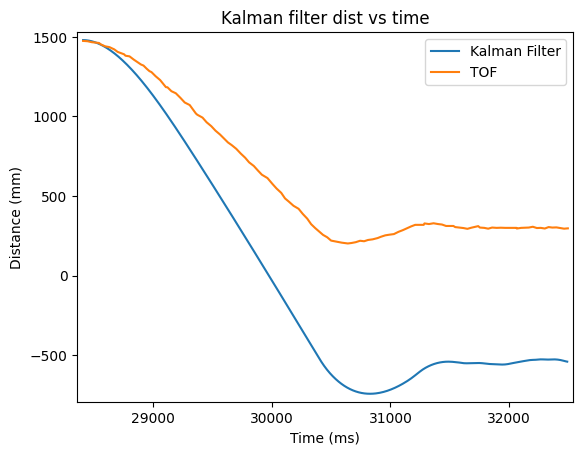

507


In [760]:
i = toft_noint[0]
j = 0
tofrange = toft_noint[len(tofa_noint)-1]
KF_dist = []
KF_time = []
us = []
newTOF = 1 #record if new tof reading or not
x = np.array([[tof_arr1[0]], [0]])
sigma = np.array([[20*2,0],[0,5**2]])

printing = False
print(tof_arr1)

while(i <= tofrange):
    '''if len(KF_dist) > 260 and len(KF_dist) < 280:
        printing = True
    else:
        printing = False'''
    KF_time.append(float(i))
    if(printing):
        print("Time: ", i, "Motor: ", motor[j], "TOF: ", tofa_noint[j], "NEW TOF: ", newTOF)
    i = i + Delt_T*1000
    x, sigma = kf(x, sigma, -(tofmotor_noint[j])/125, tofa_noint[j], newTOF, printing)
    KF_dist.append(x[0][0])
    us.append(-(tofmotor_noint[j])/166)
    if(toft_noint[j+1] <= i):
        j = j+1
        newTOF = 1

    else:
        newTOF = 0
plt.plot(KF_time, KF_dist)
plt.plot(toft_noint, tofa_noint, 0)
plt.xlim(min(KF_time) - 50, max(KF_time) + 50)
plt.ylim(min(KF_dist) - 50, max(KF_dist) + 50)
#print(toft_noint)
#plt.plot(KF_time[250:300], KF_dist[250:300], 'o',zorder=1)
#plt.scatter(toft_noint[50:100], tofa_noint[50:100],color = 'orange',zorder=2)

plt.locator_params(axis='x', nbins=5) 
plt.locator_params(axis='y', nbins=5) 
plt.legend(["Kalman Filter","TOF"], loc="upper right")
plt.title('Kalman filter dist vs time')
plt.ylabel('Distance (mm)')
plt.xlabel('Time (ms)')
plt.show()

print(len(KF_dist))

In [761]:
ble.disconnect()

Exception: Not connected to a BLE device